# Проект e-commerce

### Файлы:

<b> olist_customers_datase.csv </b>— таблица с уникальными идентификаторами пользователей <p>
<li> customer_id — позаказный идентификатор пользователя
<li> customer_unique_id —  уникальный идентификатор пользователя  (аналог номера паспорта)
<li> customer_zip_code_prefix —  почтовый индекс пользователя
<li> customer_city —  город доставки пользователя
<li> customer_state —  штат доставки пользователя <p>

<b> olist_orders_dataset.csv </b>—  таблица заказов <p>
<li> order_id —  уникальный идентификатор заказа (номер чека)
<li> customer_id —  позаказный идентификатор пользователя
<li> order_status —  статус заказа
<li> order_purchase_timestamp —  время создания заказа
<li> order_approved_at —  время подтверждения оплаты заказа
<li> order_delivered_carrier_date —  время передачи заказа в логистическую службу
<li> order_delivered_customer_date —  время доставки заказа
<li> order_estimated_delivery_date —  обещанная дата доставки <p>

<b> olist_order_items_dataset.csv </b> —  товарные позиции, входящие в заказы <p>
<li> order_id —  уникальный идентификатор заказа (номер чека)
<li> order_item_id —  идентификатор товара внутри одного заказа
<li> product_id —  ид товара (аналог штрихкода)
<li> seller_id — ид производителя товара
<li> shipping_limit_date —  максимальная дата доставки продавцом для передачи заказа партнеру по логистике
<li> price —  цена за единицу товара
<li> freight_value —  вес товара <p>

<b> Уникальные статусы заказов в таблице olist_orders_dataset:</b> <p>
<li> created —  создан
<li> approved —  подтверждён
<li> invoiced —  выставлен счёт
<li> processing —  в процессе сборки заказа
<li> shipped —  отгружен со склада
<li> delivered —  доставлен пользователю
<li> unavailable —  недоступен
<li> canceled —  отменён

## Предварительное исследование

In [136]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from datetime import timedelta
from operator import attrgetter
import requests
from urllib.parse import urlencode

In [137]:
customers = pd.read_csv('olist_customers_dataset.csv')
orders = pd.read_csv('olist_orders_dataset.csv')
order_items = pd.read_csv('olist_order_items_dataset.csv')

In [138]:
customers.dtypes

customer_id                 object
customer_unique_id          object
customer_zip_code_prefix     int64
customer_city               object
customer_state              object
dtype: object

In [139]:
order_items.dtypes

order_id                object
order_item_id            int64
product_id              object
seller_id               object
shipping_limit_date     object
price                  float64
freight_value          float64
dtype: object

In [140]:
orders.dtypes

order_id                         object
customer_id                      object
order_status                     object
order_purchase_timestamp         object
order_approved_at                object
order_delivered_carrier_date     object
order_delivered_customer_date    object
order_estimated_delivery_date    object
dtype: object

Т.к. колонки в orders и order_items object, то переведем их в тип "даты"

In [141]:
# перевод дат в тип "даты" из oders
time_col = ['order_purchase_timestamp', 
          'order_approved_at', 
          'order_delivered_carrier_date', 
          'order_delivered_customer_date', 
          'order_estimated_delivery_date']
orders[time_col] = orders[time_col].apply(lambda x: pd.to_datetime(x, format='%Y-%m-%d'))
# перевод даты в тип "даты" из order_items
order_items['shipping_limit_date'] = pd.to_datetime(order_items['shipping_limit_date'], format='%Y-%m-%d')

## Определение "покупки"
Для определение того, что считать покупкой, рассмотрим возможные статусы заказов.

Статусы created обозначают создание и является начальной стадией заказа. Однако не факт, что в итоге заказ дойдет до конечной стадии и не будет в итоге отменен. 

Статусы canceled — отменён и unavailable — недоступен нельзя считать покупкой, т.к. выполнение заказа не будет.

Таким образом, под вопросом следующие статусы:
approved - подтвержден,
invoiced — выставлен счёт,
processing — в процессе сборки заказа,
shipped — отгружен со склада,
delivered — доставлен пользователю.

Для уточнения рассмотрим более подробно.

Думаю логично, если покупка предполагает оплату, поэтому рассмотрим время подтверждение оплаты (order_approved_at) и у каких статусов есть подтверждение отплаты, а у каких нет.

In [142]:
# строки, где есть записи с отсутствующей оплатой
orders_appr_isna=orders.order_approved_at.isna()

In [143]:
# число записей без подтверждения оплаты для статусов 
# (какие статусы не имеют подтверждения оплаты)
(orders[orders_appr_isna].order_status.value_counts())

canceled     141
delivered     14
created        5
Name: order_status, dtype: int64

In [144]:
# число записей с подтверждения оплаты для статусов 
# (какие статусы имеют подтверждения оплаты)
(orders[orders_appr_isna==False].order_status.value_counts())

delivered      96464
shipped         1107
unavailable      609
canceled         484
invoiced         314
processing       301
approved           2
Name: order_status, dtype: int64

Таким образом:

created - создан и не факт, что в итоге будет покупка => отбрасываем

approved — подвтверждён и оплачен => покупка

invoiced— выставлен счёт и оплачен => покупка

processing — оплачен и собирается => покупка

shipped — оплачен и отгружен => покупка 

delivered— оплачен и доставлен => покупка  

unavailable— недоступен — заказ не может быть совершен => отбрасываем 

canceled — отменён — нельзя считать покупкой => отбрасываем  

#### Следовательно, будем считать покупкой все статусы кроме created, unavailable, canceled.

In [145]:
no_purchases=['created','unavailable','canceled']

## 1. Сколько у нас пользователей, которые совершили покупку только один раз?

Для того, чтобы оценить покупки и покупателей, объединим данные из customers и orders. Объединяем по customer_id.

In [146]:
customers_orders_merged = customers.merge(orders, on='customer_id')

Проверим, что при объединении не было ничего потеряно. Для этого сравним общее число строк в обоих таблицах.

In [147]:
# число строк orders
orders.shape[0]

99441

In [148]:
# число строк customers
customers.shape[0]

99441

In [149]:
# число customers_orders_merged
customers_orders_merged.shape[0]

99441

Число строк совпало, значит все объединилось без потерь.

In [150]:
customers_orders_merged.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15


In [151]:
# берем только покупки, статтусы которые не входят в "не покупки"
# группируем по уникальным customer_id
# считаем число покупок для каждого из уникальных покупателей
# из числа покупателей отбираем тех, кто совершил только 1 покупку
# считаем число отобранных покупателей
customers_orders_merged\
    .query('order_status not in @no_purchases')\
    .groupby('customer_unique_id', as_index=False)\
    .agg({'customer_id': 'count'})\
    .query('customer_id == 1')\
    .shape[0]

92099

## 2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?

В качестве причин возьмем статусы заказов. Нас интересуют недоставленные варианты, поэтому сразу отбрасываем заказы со статусом delivered и будем рассматривать все остальные заказы.

In [152]:
# недоставленные заказы
not_delivered_orders=orders.query('order_status != "delivered"')
not_delivered_orders

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
6,136cce7faa42fdb2cefd53fdc79a6098,ed0271e0b7da060a393796590e7b737a,invoiced,2017-04-11 12:22:08,2017-04-13 13:25:17,NaT,NaT,2017-05-09
44,ee64d42b8cf066f35eac1cf57de1aa85,caded193e8e47b8362864762a83db3c5,shipped,2018-06-04 16:44:48,2018-06-05 04:31:18,2018-06-05 14:32:00,NaT,2018-06-28
103,0760a852e4e9d89eb77bf631eaaf1c84,d2a79636084590b7465af8ab374a8cf5,invoiced,2018-08-03 17:44:42,2018-08-07 06:15:14,NaT,NaT,2018-08-21
128,15bed8e2fec7fdbadb186b57c46c92f2,f3f0e613e0bdb9c7cee75504f0f90679,processing,2017-09-03 14:22:03,2017-09-03 14:30:09,NaT,NaT,2017-10-03
154,6942b8da583c2f9957e990d028607019,52006a9383bf149a4fb24226b173106f,shipped,2018-01-10 11:33:07,2018-01-11 02:32:30,2018-01-11 19:39:23,NaT,2018-02-07
...,...,...,...,...,...,...,...,...
99283,3a3cddda5a7c27851bd96c3313412840,0b0d6095c5555fe083844281f6b093bb,canceled,2018-08-31 16:13:44,NaT,NaT,NaT,2018-10-01
99313,e9e64a17afa9653aacf2616d94c005b8,b4cd0522e632e481f8eaf766a2646e86,processing,2018-01-05 23:07:24,2018-01-09 07:18:05,NaT,NaT,2018-02-06
99347,a89abace0dcc01eeb267a9660b5ac126,2f0524a7b1b3845a1a57fcf3910c4333,canceled,2018-09-06 18:45:47,NaT,NaT,NaT,2018-09-27
99348,a69ba794cc7deb415c3e15a0a3877e69,726f0894b5becdf952ea537d5266e543,unavailable,2017-08-23 16:28:04,2017-08-28 15:44:47,NaT,NaT,2017-09-15


In [153]:
# количество недоставленных заказов по статусам
not_delivered_orders.order_status.value_counts()

shipped        1107
canceled        625
unavailable     609
invoiced        314
processing      301
created           5
approved          2
Name: order_status, dtype: int64

In [154]:
# для удобства месяц и год в отдельную колонку
not_delivered_orders['year_month_estimated']=not_delivered_orders['order_estimated_delivery_date'].dt.strftime("%Y-%m")

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [155]:
# Кол-во недоставленных по месяцам по датасету с недоставленными заказами
# Группируем по столбцу год-месяц и статусу
# Считаем кол-ко
undelivered_by_month=not_delivered_orders.\
    groupby(['year_month_estimated','order_status'], as_index=False)\
    .agg({'order_id':'count'})\
    .rename(columns={'order_id':'undelivered'})
undelivered_by_month

,year_month_estimated,order_status,undelivered
0,2016-09,canceled,1
1,2016-10,canceled,3
2,2016-10,shipped,1
3,2016-11,canceled,14
4,2016-11,invoiced,9
...,...,...,...
110,2018-08,unavailable,22
111,2018-09,canceled,49
112,2018-09,shipped,4
113,2018-10,canceled,12


Cреднее кол-во недоставленных в месяц

In [156]:
undelivered_by_month.undelivered.mean()

25.765217391304347

Посмотрим среднее число недоставленных в месяц по статусам

In [157]:
undelivered_by_month_by_status=undelivered_by_month\
    .groupby('order_status',as_index=False)\
    .agg({'undelivered':'mean'})\
    .rename(columns={'undelivered':'mean_undelivered'})\
    .sort_values('mean_undelivered',ascending=False)
undelivered_by_month_by_status

,order_status,mean_undelivered
5,shipped,48.130435
6,unavailable,29.000000
1,canceled,24.038462
4,processing,15.842105
3,invoiced,14.952381
2,created,1.666667
0,approved,1.000000


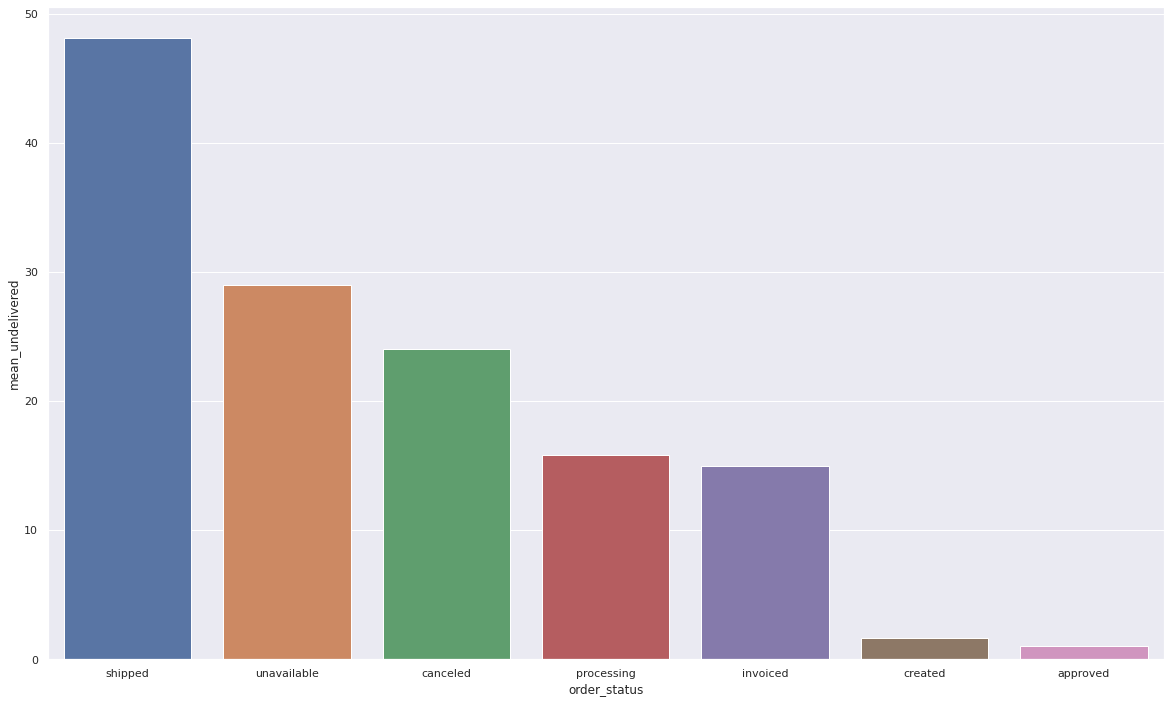

In [158]:
plt.figure(figsize=(20,12))
sns.barplot(x=undelivered_by_month_by_status.order_status,y=undelivered_by_month_by_status.mean_undelivered, data=undelivered_by_month_by_status)

Много недоставленных со статусом shipped, поэтому посмотрим на эти заказы

In [159]:
shipped=not_delivered_orders.query('order_status=="shipped"')
shipped

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,year_month_estimated
44,ee64d42b8cf066f35eac1cf57de1aa85,caded193e8e47b8362864762a83db3c5,shipped,2018-06-04 16:44:48,2018-06-05 04:31:18,2018-06-05 14:32:00,NaT,2018-06-28,2018-06
154,6942b8da583c2f9957e990d028607019,52006a9383bf149a4fb24226b173106f,shipped,2018-01-10 11:33:07,2018-01-11 02:32:30,2018-01-11 19:39:23,NaT,2018-02-07,2018-02
162,36530871a5e80138db53bcfd8a104d90,4dafe3c841d2d6cc8a8b6d25b35704b9,shipped,2017-05-09 11:48:37,2017-05-11 11:45:14,2017-05-11 13:21:47,NaT,2017-06-08,2017-06
231,4d630f57194f5aba1a3d12ce23e71cd9,6d491c9fe2f04f6e2af6ec033cd8907c,shipped,2017-11-17 19:53:21,2017-11-18 19:50:31,2017-11-22 17:28:34,NaT,2017-12-13,2017-12
299,3b4ad687e7e5190db827e1ae5a8989dd,1a87b8517b7d31373b50396eb15cb445,shipped,2018-06-28 12:52:15,2018-06-28 13:11:09,2018-07-04 15:20:00,NaT,2018-08-03,2018-08
...,...,...,...,...,...,...,...,...,...
98534,a59ef0abffbef8ddaae23600b6ee6604,49e64271fb8eeb19851dc7e850e92204,shipped,2017-11-06 17:35:49,2017-11-07 06:31:44,2017-11-07 18:57:39,NaT,2017-11-24,2017-11
98779,dab8a6c6bd6ec448df5b3a6b6cb887bc,394653a10cab83cad40d7e2713f3ab89,shipped,2018-07-14 10:12:51,2018-07-16 12:30:58,2018-07-16 14:34:00,NaT,2018-08-03,2018-08
98932,492aed3c33bac22a8e04138319829283,58466c1166c377a56f6b2ae0d93ffbc0,shipped,2018-07-06 16:26:47,2018-07-06 16:35:10,2018-07-10 12:27:00,NaT,2018-07-26,2018-07
99113,274a7f7e4f1c17b7434a830e9b8759b1,670af30ca5b8c20878fecdafa5ee01b9,shipped,2018-06-23 13:25:15,2018-06-23 13:40:11,2018-07-04 13:51:00,NaT,2018-07-24,2018-07


In [160]:
# разница между временем обещанной доставки и отгрузкой
shipped['delta_time']=shipped.order_estimated_delivery_date-shipped.order_delivered_carrier_date

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [161]:
# разница времени отрицательна, т.е. есть заказы, которые были отгружены позже времени отведенного на доставку
shipped.query('delta_time<@pd.to_timedelta(0)')

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,year_month_estimated,delta_time
6997,1b76802b72eb5517c97481ee2f7b7037,85ac32af92e4e38adeaeb0653a085dfd,shipped,2017-02-08 08:48:43,2017-02-08 08:55:11,2017-03-14 11:00:52,NaT,2017-03-10,2017-03,-5 days +12:59:08
8813,cb503219f1a73d8a4dfe8561be373c99,921822ed81e9c094d7908db16164a270,shipped,2017-11-25 11:22:09,2017-11-25 11:35:20,2018-01-04 21:41:39,NaT,2017-12-21,2017-12,-15 days +02:18:21
19637,c108072ab31ec90a754129c171577f5f,a979b3cbd898fd8be91a290a667fd0d4,shipped,2017-10-16 21:13:03,2017-10-16 21:28:13,2017-10-26 20:40:20,NaT,2017-10-26,2017-10,-1 days +03:19:40
22143,38541d08d4eb7d571b5b80cb6ca9be03,937682b4176cf634c443714be31b5ca7,shipped,2017-11-24 21:36:30,2017-11-25 01:31:42,2018-01-04 21:07:51,NaT,2017-12-20,2017-12,-16 days +02:52:09
40266,19802314932831a78e4f0e3dead30f83,cc825baf36814fe3b4354455ef9a2335,shipped,2017-11-20 11:46:03,2017-11-20 12:10:25,2017-12-14 21:35:17,NaT,2017-12-13,2017-12,-2 days +02:24:43
55472,dd0e00343af091774fc1399707418777,fa4cd2e67f0e9eb36f86d4b1413b059d,shipped,2017-03-06 19:54:12,2017-03-07 04:25:28,2017-04-03 14:32:54,NaT,2017-03-29,2017-03,-6 days +09:27:06
66818,18c89078cd21364b7ad7f4d652e0cb84,2d86160611127e9ccc6c5e70ea08f065,shipped,2017-10-17 17:16:34,2017-10-17 17:46:06,2017-11-01 22:07:45,NaT,2017-10-27,2017-10,-6 days +01:52:15
78402,28bc8f33c194dd4f636717ef490d0921,64ebc89fe827e44bf4c57f7e22676e12,shipped,2018-02-26 12:08:26,2018-02-27 10:48:37,2018-03-17 00:11:31,NaT,2018-03-12,2018-03,-6 days +23:48:29


Таким образом, в среднем в месяц не доставляется:

unavailable	29.000000 - недоступны для заказа

canceled	24.038462 - отменены

Остальные статусы представляют собой стадии, которые проходит заказ до доставки, поэтому они также "недоставленные"(что считаю логичным):

shipped	48.130435 - отгруженны, но не доставлены; есть заказы, которые огружены позже обещанного (но их мало)

processing	15.842105 -в процессе доставки, но еще не доставлены

invoiced	14.952381 - подтверждение оплаты, но еще не доставлены

created	1.666667 -еще только созданы, поэтому не доставлены

approved	1.000000 - подтверждены, но еще отправлены

## 3. По каждому товару определить, в какой день недели товар чаще всего покупается

Объединим orders и order_items по order_id

In [162]:
items=orders.merge(order_items,on='order_id',how='left')
items

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,1.0,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,1.0,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,1.0,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,1.0,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113420,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02,1.0,f1d4ce8c6dd66c47bbaa8c6781c2a923,1f9ab4708f3056ede07124aad39a2554,2018-02-12 13:10:37,174.90,20.10
113421,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27,1.0,b80910977a37536adeddd63663f916ad,d50d79cb34e38265a8649c383dcffd48,2017-09-05 15:04:16,205.99,65.02
113422,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15,1.0,d1c427060a0f73f6b889a5c7c61f2ac4,a1043bafd471dff536d0c462352beb48,2018-01-12 21:36:21,179.99,40.59
113423,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15,2.0,d1c427060a0f73f6b889a5c7c61f2ac4,a1043bafd471dff536d0c462352beb48,2018-01-12 21:36:21,179.99,40.59


In [163]:
items.product_id.nunique()

32951

In [164]:
# Обозначим дни недели
items['weekday']=items['order_purchase_timestamp'].dt.day_name()

In [165]:
# посчитаем число покупок по дням неделям для каждого товара
items=items.groupby(['product_id','weekday'],as_index=False).agg({'price':'count'})
items

,product_id,weekday,price
0,00066f42aeeb9f3007548bb9d3f33c38,Sunday,1
1,00088930e925c41fd95ebfe695fd2655,Tuesday,1
2,0009406fd7479715e4bef61dd91f2462,Thursday,1
3,000b8f95fcb9e0096488278317764d19,Friday,1
4,000b8f95fcb9e0096488278317764d19,Wednesday,1
...,...,...,...
61225,fffdb2d0ec8d6a61f0a0a0db3f25b441,Friday,1
61226,fffdb2d0ec8d6a61f0a0a0db3f25b441,Sunday,1
61227,fffdb2d0ec8d6a61f0a0a0db3f25b441,Thursday,1
61228,fffdb2d0ec8d6a61f0a0a0db3f25b441,Tuesday,2


In [166]:
# сводная таблица: в какой день недели какой товар чаще был куплен
items.pivot(index='product_id',columns='weekday',values='price').idxmax(axis=1).to_frame().rename(columns={0:'popular_day'}).reset_index()

,product_id,popular_day
0,00066f42aeeb9f3007548bb9d3f33c38,Sunday
1,00088930e925c41fd95ebfe695fd2655,Tuesday
2,0009406fd7479715e4bef61dd91f2462,Thursday
3,000b8f95fcb9e0096488278317764d19,Friday
4,000d9be29b5207b54e86aa1b1ac54872,Tuesday
...,...,...
32946,fff6177642830a9a94a0f2cba5e476d1,Saturday
32947,fff81cc3158d2725c0655ab9ba0f712c,Monday
32948,fff9553ac224cec9d15d49f5a263411f,Friday
32949,fffdb2d0ec8d6a61f0a0a0db3f25b441,Tuesday


## 4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? 
### Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть.

In [167]:
# объединим таблицы покупателей, заказов и товарные позиции только с покупками
all_purchases=customers_orders_merged.merge(order_items,on='order_id').query('order_status not in @no_purchases')
all_purchases.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2017-05-22 15:22:12,124.99,21.88
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-01-18 20:58:32,289.00,46.48
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13,1,bd07b66896d6f1494f5b86251848ced7,7c67e1448b00f6e969d365cea6b010ab,2018-06-05 16:19:10,139.94,17.79
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10,1,a5647c44af977b148e0a3a4751a09e2e,7c67e1448b00f6e969d365cea6b010ab,2018-03-27 16:31:16,149.94,23.36
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15,1,9391a573abe00141c56e38d84d7d5b3b,4a3ca9315b744ce9f8e9374361493884,2018-07-31 10:10:09,230.00,22.25


In [168]:
all_purchases['year_month_orders'] = all_purchases.order_purchase_timestamp.to_numpy().astype('datetime64[M]')
all_purchases['weekday']=all_purchases['order_purchase_timestamp'].dt.day_name()
all_purchases.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,year_month_orders,weekday
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2017-05-22 15:22:12,124.99,21.88,2017-05-01,Tuesday
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-01-18 20:58:32,289.00,46.48,2018-01-01,Friday
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13,1,bd07b66896d6f1494f5b86251848ced7,7c67e1448b00f6e969d365cea6b010ab,2018-06-05 16:19:10,139.94,17.79,2018-05-01,Saturday
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10,1,a5647c44af977b148e0a3a4751a09e2e,7c67e1448b00f6e969d365cea6b010ab,2018-03-27 16:31:16,149.94,23.36,2018-03-01,Tuesday
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15,1,9391a573abe00141c56e38d84d7d5b3b,4a3ca9315b744ce9f8e9374361493884,2018-07-31 10:10:09,230.00,22.25,2018-07-01,Sunday


In [169]:
# среднее число покупок в месяц
avg_orders_by_month=all_purchases\
    .groupby('year_month_orders',as_index=False)\
    .agg({'order_id':'nunique'})\
    .rename(columns={'order_id':'orders_by_month'})
avg_orders_by_month

,year_month_orders,orders_by_month
0,2016-09-01,2
1,2016-10-01,290
2,2016-12-01,1
3,2017-01-01,787
4,2017-02-01,1718
5,2017-03-01,2617
6,2017-04-01,2377
7,2017-05-01,3640
8,2017-06-01,3205
9,2017-07-01,3946


In [170]:
avg_orders_by_month.year_month_orders.dt.days_in_month / 7

0     4.285714
1     4.428571
2     4.428571
3     4.428571
4     4.000000
5     4.428571
6     4.285714
7     4.428571
8     4.285714
9     4.428571
10    4.428571
11    4.285714
12    4.428571
13    4.285714
14    4.428571
15    4.428571
16    4.000000
17    4.428571
18    4.285714
19    4.428571
20    4.285714
21    4.428571
22    4.428571
23    4.285714
Name: year_month_orders, dtype: float64

In [171]:
# Считаем сколько у всех пользователей в среднем покупок в неделю
avg_orders_by_month['orders_by_week'] = avg_orders_by_month.orders_by_month/(avg_orders_by_month.year_month_orders.dt.days_in_month / 7)
avg_orders_by_month

,year_month_orders,orders_by_month,orders_by_week
0,2016-09-01,2,0.466667
1,2016-10-01,290,65.483871
2,2016-12-01,1,0.225806
3,2017-01-01,787,177.709677
4,2017-02-01,1718,429.500000
5,2017-03-01,2617,590.935484
6,2017-04-01,2377,554.633333
7,2017-05-01,3640,821.935484
8,2017-06-01,3205,747.833333
9,2017-07-01,3946,891.032258


## 5. Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц.

In [172]:
all_purchases['order_purchase_timestamp']=all_purchases['order_purchase_timestamp'].dt.to_period('M') 

In [173]:
# создаем когорты
cohorts = all_purchases.groupby('customer_unique_id', as_index=False)['order_purchase_timestamp']\
    .min()\
    .rename(columns={'order_purchase_timestamp':'cohort'})
cohorts

,customer_unique_id,cohort
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05
2,0000f46a3911fa3c0805444483337064,2017-03
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10
4,0004aac84e0df4da2b147fca70cf8255,2017-11
...,...,...
94978,fffcf5a5ff07b0908bd4e2dbc735a684,2017-06
94979,fffea47cd6d3cc0a88bd621562a9d061,2017-12
94980,ffff371b4d645b6ecea244b27531430a,2017-02
94981,ffff5962728ec6157033ef9805bacc48,2018-05


In [174]:
# объединяем таблицы когорт с общей таблицей по покупателям, даты станут целевыми
df_cohorts = cohorts.merge(all_purchases[['customer_unique_id','order_purchase_timestamp']], how='left', on='customer_unique_id')\
    .rename(columns={'order_purchase_timestamp': 'target_action_dates'})
df_cohorts

,customer_unique_id,cohort,target_action_dates
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05,2018-05
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05,2018-05
2,0000f46a3911fa3c0805444483337064,2017-03,2017-03
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10,2017-10
4,0004aac84e0df4da2b147fca70cf8255,2017-11,2017-11
...,...,...,...
112096,fffcf5a5ff07b0908bd4e2dbc735a684,2017-06,2017-06
112097,fffea47cd6d3cc0a88bd621562a9d061,2017-12,2017-12
112098,ffff371b4d645b6ecea244b27531430a,2017-02,2017-02
112099,ffff5962728ec6157033ef9805bacc48,2018-05,2018-05


In [175]:
# группируем по когортам и посчитаем число покупателей для каждой
df_cohorts=df_cohorts.groupby(['cohort', 'target_action_dates'], as_index=False)\
    .agg({'customer_unique_id': 'nunique'})\
    .rename(columns={'customer_unique_id':'customer_count'})
df_cohorts

,cohort,target_action_dates,customer_count
0,2016-09,2016-09,2
1,2016-10,2016-10,287
2,2016-10,2017-04,1
3,2016-10,2017-07,1
4,2016-10,2017-09,1
...,...,...,...
215,2018-06,2018-08,16
216,2018-07,2018-07,6017
217,2018-07,2018-08,31
218,2018-08,2018-08,6209


In [176]:
# разница между первой и последующей покупкой
df_cohorts['period']=df_cohorts.target_action_dates-df_cohorts.cohort
df_cohorts['period']=df_cohorts.period.apply(attrgetter('n'))

In [177]:
# сводная таблица (число покупателей по когортам)
cohorts_pivot=df_cohorts.pivot(index='cohort',columns='period',values='customer_count')
cohorts_pivot

period,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19,20
cohort,,,,,,,,,,,,,,,,,,,,
2016-09,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10,287.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,2.0,2.0
2016-12,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01,752.0,3.0,2.0,1.0,3.0,1.0,3.0,1.0,1.0,NaN,3.0,1.0,5.0,3.0,1.0,1.0,2.0,3.0,1.0,NaN
2017-02,1690.0,4.0,5.0,2.0,7.0,2.0,4.0,3.0,2.0,3.0,2.0,5.0,2.0,3.0,2.0,1.0,1.0,4.0,NaN,NaN
2017-03,2571.0,13.0,9.0,10.0,9.0,4.0,4.0,8.0,9.0,2.0,10.0,3.0,6.0,3.0,4.0,6.0,2.0,4.0,NaN,NaN
2017-04,2325.0,14.0,5.0,4.0,7.0,6.0,8.0,7.0,7.0,4.0,6.0,2.0,2.0,1.0,2.0,2.0,3.0,NaN,NaN,NaN
2017-05,3541.0,17.0,17.0,14.0,11.0,12.0,15.0,5.0,9.0,9.0,9.0,12.0,9.0,1.0,7.0,8.0,NaN,NaN,NaN,NaN
2017-06,3102.0,14.0,11.0,12.0,8.0,12.0,11.0,7.0,4.0,7.0,10.0,10.0,5.0,4.0,6.0,NaN,NaN,NaN,NaN,NaN


In [178]:
# сводная таблица retention
# размер когорты=кол-во пользователей в 0 период
retention=cohorts_pivot.div(cohorts_pivot.iloc[:,0],axis=0)
retention

period,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19,20
cohort,,,,,,,,,,,,,,,,,,,,
2016-09,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10,1.0,NaN,NaN,NaN,NaN,NaN,0.003484,NaN,NaN,0.003484,NaN,0.003484,NaN,0.003484,NaN,0.003484,NaN,0.003484,0.006969,0.006969
2016-12,1.0,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01,1.0,0.003989,0.002660,0.001330,0.003989,0.001330,0.003989,0.001330,0.001330,NaN,0.003989,0.001330,0.006649,0.003989,0.001330,0.001330,0.002660,0.003989,0.001330,NaN
2017-02,1.0,0.002367,0.002959,0.001183,0.004142,0.001183,0.002367,0.001775,0.001183,0.001775,0.001183,0.002959,0.001183,0.001775,0.001183,0.000592,0.000592,0.002367,NaN,NaN
2017-03,1.0,0.005056,0.003501,0.003890,0.003501,0.001556,0.001556,0.003112,0.003501,0.000778,0.003890,0.001167,0.002334,0.001167,0.001556,0.002334,0.000778,0.001556,NaN,NaN
2017-04,1.0,0.006022,0.002151,0.001720,0.003011,0.002581,0.003441,0.003011,0.003011,0.001720,0.002581,0.000860,0.000860,0.000430,0.000860,0.000860,0.001290,NaN,NaN,NaN
2017-05,1.0,0.004801,0.004801,0.003954,0.003106,0.003389,0.004236,0.001412,0.002542,0.002542,0.002542,0.003389,0.002542,0.000282,0.001977,0.002259,NaN,NaN,NaN,NaN
2017-06,1.0,0.004513,0.003546,0.003868,0.002579,0.003868,0.003546,0.002257,0.001289,0.002257,0.003224,0.003224,0.001612,0.001289,0.001934,NaN,NaN,NaN,NaN,NaN


Таблицу retention для наглядности построим "красиво" 

In [179]:
ur_style = (retention
            .style 
            .set_caption('Customer retention by cohort')  # подпись 
            .background_gradient(cmap='viridis')          # раскрашивание ячеек по столбцам 
            .highlight_null('white')                      # белый фон для NaN 
            .format("{:.2%}", na_rep=""))                 # числа как проценты, NaN- пустота 
ur_style

period,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19,20
cohort,,,,,,,,,,,,,,,,,,,,
2016-09,100.00%,,,,,,,,,,,,,,,,,,,
2016-10,100.00%,,,,,,0.35%,,,0.35%,,0.35%,,0.35%,,0.35%,,0.35%,0.70%,0.70%
2016-12,100.00%,100.00%,,,,,,,,,,,,,,,,,,
2017-01,100.00%,0.40%,0.27%,0.13%,0.40%,0.13%,0.40%,0.13%,0.13%,,0.40%,0.13%,0.66%,0.40%,0.13%,0.13%,0.27%,0.40%,0.13%,
2017-02,100.00%,0.24%,0.30%,0.12%,0.41%,0.12%,0.24%,0.18%,0.12%,0.18%,0.12%,0.30%,0.12%,0.18%,0.12%,0.06%,0.06%,0.24%,,
2017-03,100.00%,0.51%,0.35%,0.39%,0.35%,0.16%,0.16%,0.31%,0.35%,0.08%,0.39%,0.12%,0.23%,0.12%,0.16%,0.23%,0.08%,0.16%,,
2017-04,100.00%,0.60%,0.22%,0.17%,0.30%,0.26%,0.34%,0.30%,0.30%,0.17%,0.26%,0.09%,0.09%,0.04%,0.09%,0.09%,0.13%,,,
2017-05,100.00%,0.48%,0.48%,0.40%,0.31%,0.34%,0.42%,0.14%,0.25%,0.25%,0.25%,0.34%,0.25%,0.03%,0.20%,0.23%,,,,
2017-06,100.00%,0.45%,0.35%,0.39%,0.26%,0.39%,0.35%,0.23%,0.13%,0.23%,0.32%,0.32%,0.16%,0.13%,0.19%,,,,,


Когорта с максимальным retention на третий месяц (с января по декабрь 2017 г.)

In [180]:
retention.loc['2017-01':'2017-12', 3].idxmax()

Period('2017-05', 'M')

## 6. Часто для качественного анализа аудитории использую подходы, основанные на сегментации. Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию.

### Метрики RFM
R - время от последней покупки пользователя до текущей даты (как давно осуществлялась покупка)

F - суммарное количество покупок у пользователя за всё время(как часто покупают)

M - сумма покупок за всё время (как много тратят). 

In [181]:
orders=customers_orders_merged.merge(order_items,on='order_id').query('order_status not in @no_purchases')
orders

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2017-05-22 15:22:12,124.99,21.88
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-01-18 20:58:32,289.00,46.48
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13,1,bd07b66896d6f1494f5b86251848ced7,7c67e1448b00f6e969d365cea6b010ab,2018-06-05 16:19:10,139.94,17.79
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10,1,a5647c44af977b148e0a3a4751a09e2e,7c67e1448b00f6e969d365cea6b010ab,2018-03-27 16:31:16,149.94,23.36
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15,1,9391a573abe00141c56e38d84d7d5b3b,4a3ca9315b744ce9f8e9374361493884,2018-07-31 10:10:09,230.00,22.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112645,17ddf5dd5d51696bb3d7c6291687be6f,1a29b476fee25c95fbafc67c5ac95cf8,3937,sao paulo,SP,6760e20addcf0121e9d58f2f1ff14298,delivered,2018-04-07 15:48:17,2018-04-07 16:08:45,2018-04-11 02:08:36,2018-04-13 20:06:37,2018-04-25,1,ccb4503d9d43d245d3b295d0544f988b,527801b552d0077ffd170872eb49683b,2018-04-12 16:08:45,74.90,13.88
112646,e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d,6764,taboao da serra,SP,9ec0c8947d973db4f4e8dcf1fbfa8f1b,delivered,2018-04-04 08:20:22,2018-04-04 08:35:12,2018-04-05 18:42:35,2018-04-11 18:54:45,2018-04-20,1,9ede6b0570a75a4b9de4f383329f99ee,3fd1e727ba94cfe122d165e176ce7967,2018-04-10 08:35:12,114.90,14.16
112647,5e28dfe12db7fb50a4b2f691faecea5e,e9f50caf99f032f0bf3c55141f019d99,60115,fortaleza,CE,fed4434add09a6f332ea398efd656a5c,delivered,2018-04-08 20:11:50,2018-04-08 20:30:03,2018-04-09 17:52:17,2018-05-09 19:03:15,2018-05-02,1,7a5d2e1e131a860ae7d18f6fffa9d689,d9e7e7778b32987280a6f2cb9a39c57d,2018-04-12 20:30:03,37.00,19.04
112648,56b18e2166679b8a959d72dd06da27f9,73c2643a0a458b49f58cea58833b192e,92120,canoas,RS,e31ec91cea1ecf97797787471f98a8c2,delivered,2017-11-03 21:08:33,2017-11-03 21:31:20,2017-11-06 18:24:41,2017-11-16 19:58:39,2017-12-05,1,f819f0c84a64f02d3a5606ca95edd272,4869f7a5dfa277a7dca6462dcf3b52b2,2017-11-09 21:15:51,689.00,22.07


In [182]:
first_order_date = orders\
    .order_purchase_timestamp\
    .min()
first_order_date

Timestamp('2016-09-04 21:15:19')

In [183]:
last_order_date = orders\
    .order_purchase_timestamp\
    .max()
last_order_date

Timestamp('2018-09-03 09:06:57')

Вместо текущей даты для дельты между текущей датой и датой последней покупки возьмем дату самой последней покупки из таблицы `+ 1 день`. Как если бы анализ проводился на день позже; дата на день позже последнего заказа станет ориентиром для recency.

In [184]:
date_max=last_order_date+timedelta(days=1)
date_max

Timestamp('2018-09-04 09:06:57')

Один год является обычно используемым значением в сегментации RFM, поэтому period = 365 дней, а начальную дату смотрим за год до последнего заказа. Таким образом, период исследования будет ровно один год.

In [185]:
period=365

In [186]:
start_date=last_order_date-pd.Timedelta(365, unit='day')

### Recency, Frequency, Monetary

Добавлю столбец с количеством дней между покупкой и настоящим моментом

In [187]:
orders['DaysSinceOrder'] = orders['order_purchase_timestamp'].apply(lambda x: (date_max - x).days)
orders

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,DaysSinceOrder
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2017-05-22 15:22:12,124.99,21.88,475
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-01-18 20:58:32,289.00,46.48,234
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13,1,bd07b66896d6f1494f5b86251848ced7,7c67e1448b00f6e969d365cea6b010ab,2018-06-05 16:19:10,139.94,17.79,107
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10,1,a5647c44af977b148e0a3a4751a09e2e,7c67e1448b00f6e969d365cea6b010ab,2018-03-27 16:31:16,149.94,23.36,174
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15,1,9391a573abe00141c56e38d84d7d5b3b,4a3ca9315b744ce9f8e9374361493884,2018-07-31 10:10:09,230.00,22.25,36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112645,17ddf5dd5d51696bb3d7c6291687be6f,1a29b476fee25c95fbafc67c5ac95cf8,3937,sao paulo,SP,6760e20addcf0121e9d58f2f1ff14298,delivered,2018-04-07 15:48:17,2018-04-07 16:08:45,2018-04-11 02:08:36,2018-04-13 20:06:37,2018-04-25,1,ccb4503d9d43d245d3b295d0544f988b,527801b552d0077ffd170872eb49683b,2018-04-12 16:08:45,74.90,13.88,149
112646,e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d,6764,taboao da serra,SP,9ec0c8947d973db4f4e8dcf1fbfa8f1b,delivered,2018-04-04 08:20:22,2018-04-04 08:35:12,2018-04-05 18:42:35,2018-04-11 18:54:45,2018-04-20,1,9ede6b0570a75a4b9de4f383329f99ee,3fd1e727ba94cfe122d165e176ce7967,2018-04-10 08:35:12,114.90,14.16,153
112647,5e28dfe12db7fb50a4b2f691faecea5e,e9f50caf99f032f0bf3c55141f019d99,60115,fortaleza,CE,fed4434add09a6f332ea398efd656a5c,delivered,2018-04-08 20:11:50,2018-04-08 20:30:03,2018-04-09 17:52:17,2018-05-09 19:03:15,2018-05-02,1,7a5d2e1e131a860ae7d18f6fffa9d689,d9e7e7778b32987280a6f2cb9a39c57d,2018-04-12 20:30:03,37.00,19.04,148
112648,56b18e2166679b8a959d72dd06da27f9,73c2643a0a458b49f58cea58833b192e,92120,canoas,RS,e31ec91cea1ecf97797787471f98a8c2,delivered,2017-11-03 21:08:33,2017-11-03 21:31:20,2017-11-06 18:24:41,2017-11-16 19:58:39,2017-12-05,1,f819f0c84a64f02d3a5606ca95edd272,4869f7a5dfa277a7dca6462dcf3b52b2,2017-11-09 21:15:51,689.00,22.07,304


#### Recency - дельта, которая показывает, когда была совершена последняя покупка. Чем этот показатель ниже, тем нам лучше. Анализ за год от start_date.

In [188]:
recency=orders.query('order_purchase_timestamp >= @start_date')\
    .groupby('customer_unique_id')\
    .agg({'DaysSinceOrder':'min'})\
    .reset_index()\
    .rename(columns={'DaysSinceOrder': 'recency'})
recency

,customer_unique_id,recency
0,0000366f3b9a7992bf8c76cfdf3221e2,116
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119
2,0000f6ccb0745a6a4b88665a16c9f078,326
3,0004aac84e0df4da2b147fca70cf8255,293
4,0004bd2a26a76fe21f786e4fbd80607f,151
...,...,...
73066,fffb09418989a0dbff854a28163e47c6,260
73067,fffbf87b7a1a6fa8b03f081c5f51a201,250
73068,fffcc512b7dfecaffd80f13614af1d16,146
73069,fffea47cd6d3cc0a88bd621562a9d061,267


#### Frequency - число заказов на одного пользователя за анализируемый период, в данном случаи за год.

In [189]:
frequency=orders.query('order_purchase_timestamp >= @start_date')\
    .groupby('customer_unique_id',as_index=False)\
    .agg({'order_purchase_timestamp': 'count'})\
    .rename(columns={'order_purchase_timestamp': 'frequency'})
frequency

,customer_unique_id,frequency
0,0000366f3b9a7992bf8c76cfdf3221e2,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1
2,0000f6ccb0745a6a4b88665a16c9f078,1
3,0004aac84e0df4da2b147fca70cf8255,1
4,0004bd2a26a76fe21f786e4fbd80607f,1
...,...,...
73066,fffb09418989a0dbff854a28163e47c6,1
73067,fffbf87b7a1a6fa8b03f081c5f51a201,1
73068,fffcc512b7dfecaffd80f13614af1d16,1
73069,fffea47cd6d3cc0a88bd621562a9d061,1


#### Monetary - сумма, потраченная покупателем. 

In [190]:
monetary = orders.query('order_purchase_timestamp >= @start_date')\
    .groupby('customer_unique_id', as_index=False)\
    .agg({'price': 'sum'})\
    .rename(columns={'price': 'monetary'})
monetary

,customer_unique_id,monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,18.90
2,0000f6ccb0745a6a4b88665a16c9f078,25.99
3,0004aac84e0df4da2b147fca70cf8255,180.00
4,0004bd2a26a76fe21f786e4fbd80607f,154.00
...,...,...
73066,fffb09418989a0dbff854a28163e47c6,58.00
73067,fffbf87b7a1a6fa8b03f081c5f51a201,149.00
73068,fffcc512b7dfecaffd80f13614af1d16,688.00
73069,fffea47cd6d3cc0a88bd621562a9d061,64.89


#### Объединяем все найденные метрики в одну таблицу

In [191]:
rfm = recency.merge(frequency, on='customer_unique_id').merge(monetary)\
    .rename(columns={'order_purchase_timestamp': 'recency', 'order_purchase_timestamp_y': 'frequency'})
rfm

,customer_unique_id,recency,frequency,monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,116,1,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,18.90
2,0000f6ccb0745a6a4b88665a16c9f078,326,1,25.99
3,0004aac84e0df4da2b147fca70cf8255,293,1,180.00
4,0004bd2a26a76fe21f786e4fbd80607f,151,1,154.00
...,...,...,...,...
73066,fffb09418989a0dbff854a28163e47c6,260,1,58.00
73067,fffbf87b7a1a6fa8b03f081c5f51a201,250,1,149.00
73068,fffcc512b7dfecaffd80f13614af1d16,146,1,688.00
73069,fffea47cd6d3cc0a88bd621562a9d061,267,1,64.89


### Распределение recency

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


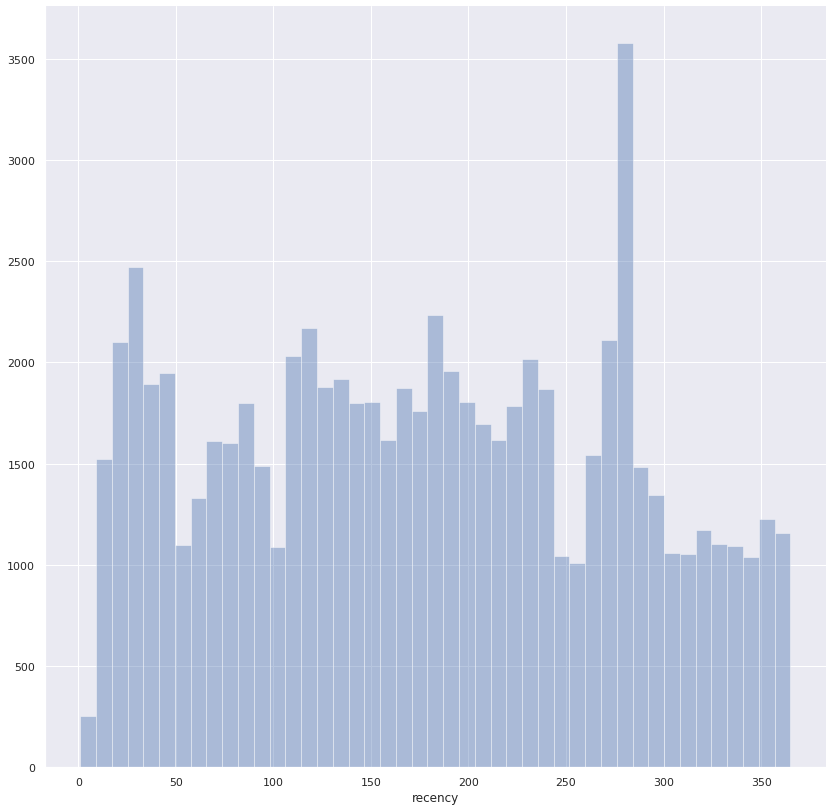

In [192]:
sns.distplot(rfm.recency, kde=False)
sns.despine()

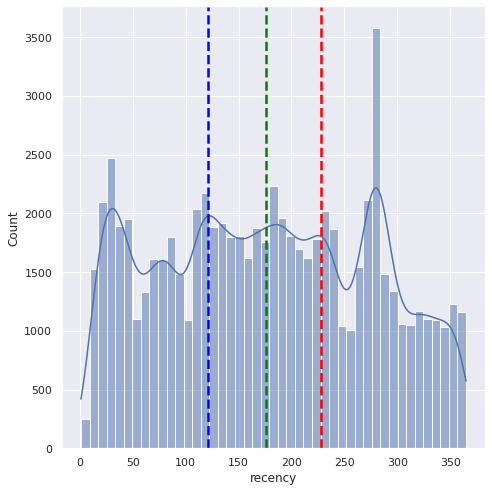

In [193]:
sns.displot(rfm.recency, height=7, aspect=1, kde=True)

plt.axvline(x=rfm.recency.median(),               # зелёная пунктирная линия - медиана
            color='green',
            ls='--', 
            lw=2.5)
plt.axvline(x=rfm.recency.quantile(q=0.33),       # синяя пунктирная линия - 33-й процентиль
            color='blue',
            ls='--', 
            lw=2.5)
plt.axvline(x=rfm.recency.quantile(q=0.66),       # фиолетовая пунктирная линия - 66-й процентиль
            color='red',
            ls='--', 
            lw=2.5)

In [194]:
rfm.recency.quantile(q=[0.33, 0.66])

0.33    121.0
0.66    228.0
Name: recency, dtype: float64

Анализ графиков показывает, что при таком распределении имеет смысл взять рвные части по количеству пользователей соответствующих 33-му и 66-му процентилю.  
Группа 3 - от 0 до 120 дней     (недавние)  
Группа 2 - от 121 до 228 дней   (относительно недавние)  
Группа 1 - от 228 дней и более  (давние)  

Разобъем **Recency** на три периода. Последний будет лежать за отметкой `в 228 дней`, как показал нам `квантиль=0.66`, граница первого закончится чуть раньше квантиля в `0.33`, возьмем `120`.

In [195]:
def R(recency):
    if recency <= 120:
        return 3
    elif recency > 228:
        return 1
    else:
        return 2

rfm['r'] = rfm.recency.apply(R)

### Распределение frequency

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


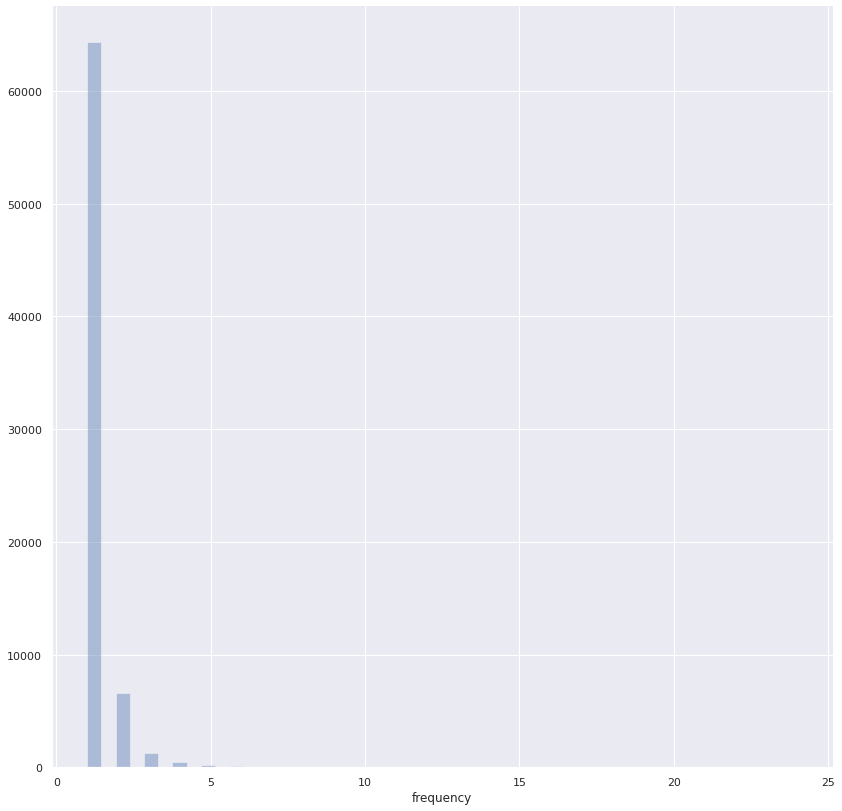

In [196]:
sns.distplot(rfm.frequency, kde=False)
sns.despine()

In [197]:
rfm.frequency.value_counts()

1     64300
2      6632
3      1256
4       442
5       195
6       151
7        36
8        13
9        11
10       10
11        8
12        8
14        3
13        2
20        1
15        1
18        1
24        1
Name: frequency, dtype: int64

In [198]:
print(round(rfm.frequency.value_counts()[1] / rfm.frequency.count()*100),'% совершили только 1 покупку')

88 % совершили только 1 покупку


In [199]:
print(round(rfm.frequency.value_counts()[2] / rfm.frequency.count()*100),'% совершили 2 покупки')

9 % совершили 2 покупки


In [200]:
print(round(rfm.frequency.value_counts()[3] / rfm.frequency.count()*100),'% совершили 3 покупки')

2 % совершили 3 покупки


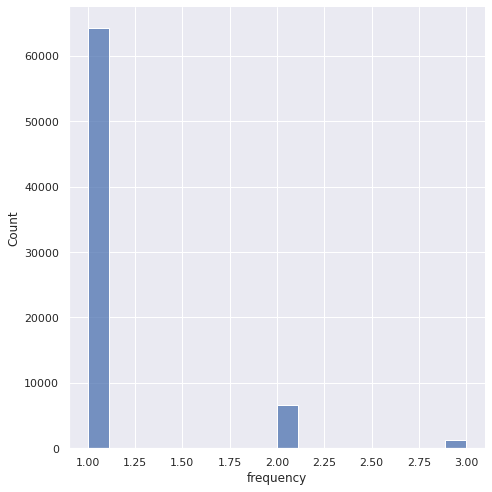

In [201]:
# распределение до 3х покупок
sns.displot(rfm.frequency[rfm.frequency<=3], height=7)

Глядя на цифры и распределение видим, что общую массу покупателей можно разделить на 3 группы. 
Преобладают покупатели с одним количеством заказов - 64300 (88%). Эту часть покупателей определим в группу №1. Число покупателей, сделавших только 2 покупки - 6632 - группа №2. В третью группу возьмём оставшихся с числом покупок 3 и более.  
Итак:  
Группа 1 - только один заказ.  
Группа 2 - только два заказа.  
Группа 3 - 3 и более заказов.  

In [202]:
def F(frequency):
    if frequency == 1:
        return 1
    elif frequency == 2:
        return 2
    else:
        return 3

rfm['f'] = rfm.frequency.apply(F)

### Распределение monetary

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


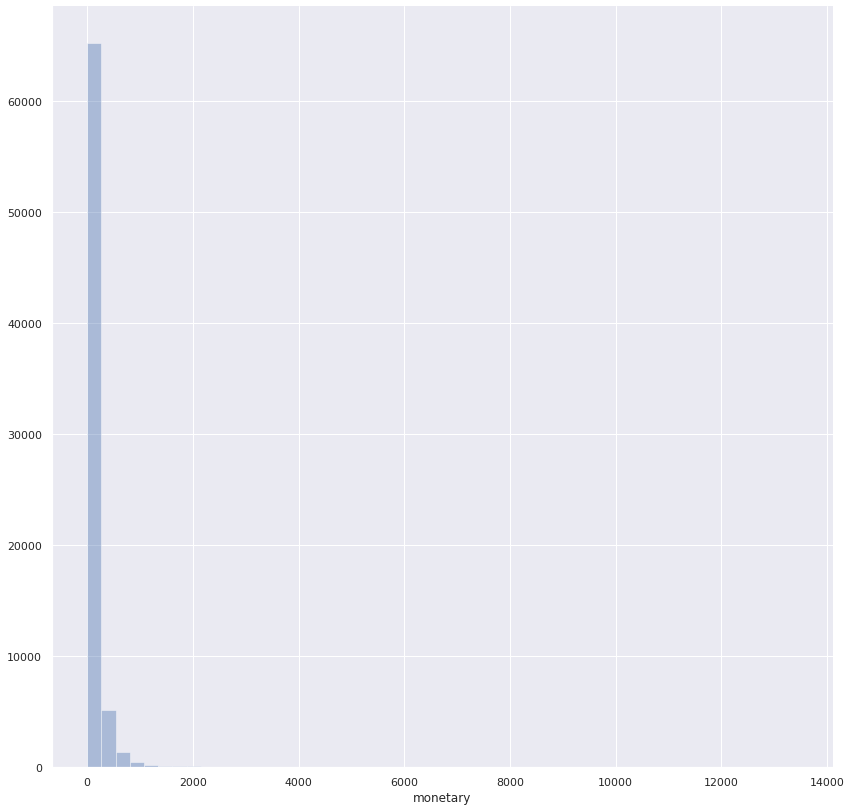

In [203]:
sns.distplot(rfm.monetary, kde=False)
sns.despine()

In [204]:
rfm.monetary.describe()

count    73071.000000
mean       141.218957
std        211.852774
min          0.850000
25%         47.900000
50%         89.900000
75%        152.800000
max      13440.000000
Name: monetary, dtype: float64

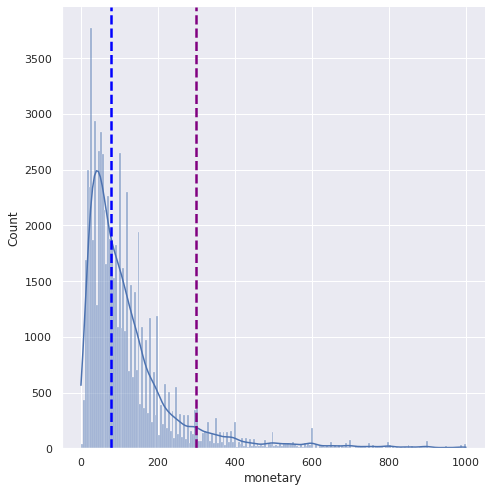

In [205]:
# распределение средних чеков покупателя, левая часть более детально (менее 1000)
sns.displot(rfm.monetary[rfm.monetary < 1000], height=7, aspect=1, kde=True)

plt.axvline(x=80,              # синяя пунктирная линия - граница между 1 и 2 группами
            color='blue',
            ls='--', 
            lw=2.5)
plt.axvline(x=300,             # фиолетовая пунктирная линия - граница между 2 и 3 группами
            color='purple',
            ls='--', 
            lw=2.5)

Пусть:  
Группа 1 - менее 80 (от 0 до значения чуть меньшего медианы)  
Группа 2 - от 80 до 300.  
Группа 3 - 300 и более.  

In [206]:
def M(monetary):
    if monetary <= 80:
        return 1
    elif monetary > 300:
        return 3
    else:
        return 2

rfm['m'] = rfm.monetary.apply(M)

### RFM

In [207]:
# Результиирующая таблица по каждому покупателю по каждому rfm кластеру
rfm['RFM'] = rfm['r'].astype(str) + rfm['f'].astype(str) + rfm['m'].astype(str)
rfm.head()

,customer_unique_id,recency,frequency,monetary,r,f,m,RFM
0,0000366f3b9a7992bf8c76cfdf3221e2,116,1,129.90,3,1,2,312
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,18.90,3,1,1,311
2,0000f6ccb0745a6a4b88665a16c9f078,326,1,25.99,1,1,1,111
3,0004aac84e0df4da2b147fca70cf8255,293,1,180.00,1,1,2,112
4,0004bd2a26a76fe21f786e4fbd80607f,151,1,154.00,2,1,2,212


In [208]:
# Кластеры со средними значениями групп
clusters = rfm.groupby('RFM',as_index=False).agg({'recency': 'mean', 'frequency': 'mean', 'monetary': 'mean'}).round(1)
clusters.index.names = ['cluster']
clusters.index += 1
clusters

,RFM,recency,frequency,monetary
cluster,,,,
1,111,290.3,1.0,44.8
2,112,289.4,1.0,147.6
3,113,293.1,1.0,623.8
4,121,290.5,2.0,54.8
5,122,289.2,2.0,158.6
6,123,291.8,2.0,564.8
7,131,293.6,3.6,57.3
8,132,291.7,3.5,171.0
9,133,294.8,4.4,708.7


In [209]:
# число кластеров
clusters.value_counts().count()

27

In [210]:
# Число покупателей в кластерах
rfm_customers = rfm.groupby('RFM', as_index=False) \
               .agg({'customer_unique_id': 'count'}) \
               .rename(columns={'customer_unique_id': 'num_of_customers'})

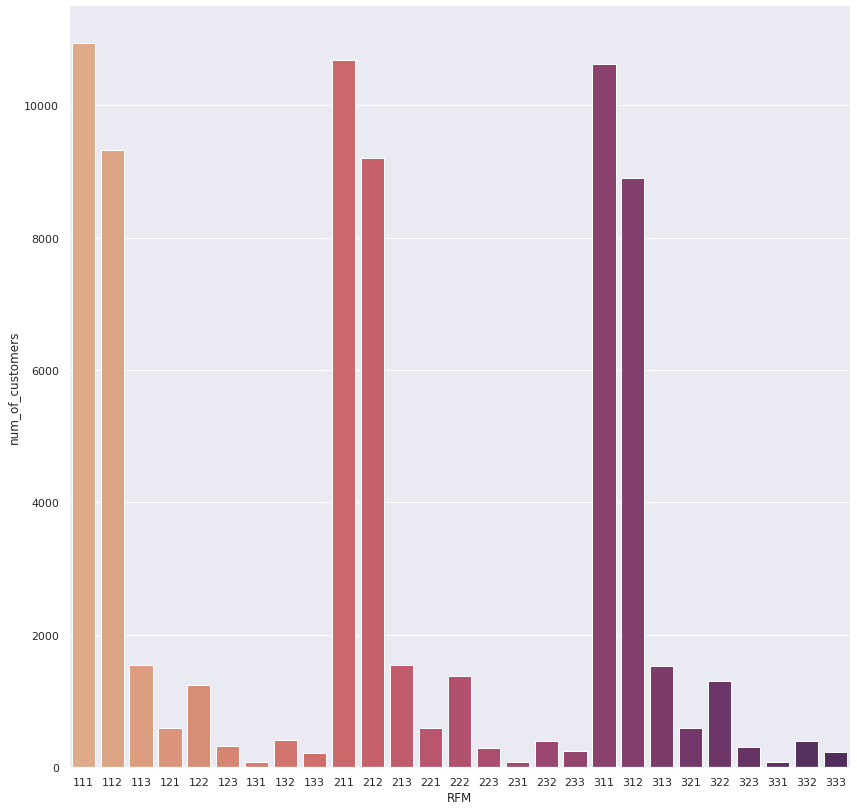

In [211]:
# Распределения клиентов по кластерам
sns.set(rc={'figure.figsize':(14,14)})
sns.barplot(data=rfm_customers, x='RFM', y='num_of_customers', palette="flare")
sns.despine()